# Table of Contents
* [Loading data](#Loading-data)
* [Object counts](#Object-counts)
* [Image brightness](#Image-brightness)
* [Look at v2 matlab files](#Look-at-v2-matlab-files)
* [Build dataset scaffolding](#Build-dataset-scaffolding)
	* [explore](#explore)
	* [code](#code)
* [hide](#hide)


In [637]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

In [638]:
%%capture
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light solarized
#%base16_mplrc dark solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)

In [639]:
import glob
import os
import json
import re
import PIL.Image as Image
import PIL.ImageStat as ImageStat
from multiprocessing import Pool
from tqdm import tqdm

# Loading data

In [640]:
all_ds_files = glob.glob('./SUNRGBD/**', recursive=True)
len(all_ds_files)

410709

In [641]:
image_names[2000]

'./SUNRGBD/kv1/NYUdata/NYU1447/image/NYU1447.jpg'

In [642]:
image_names = [iname for iname in all_ds_files if 'image/' in iname]
img_numbs = sorted([i.split('/')[-1].split('.jpg')[0] for i in image_names])
len(image_names)

10335

In [643]:
d2_anno_names = [iname for iname in all_ds_files if 'annotation2Dfinal/' in iname and not 'json_' in iname]
d3_anno_names = [iname for iname in all_ds_files if 'annotation3Dfinal/' in iname and not 'json_' in iname]
d2_3_anno_names = [iname for iname in all_ds_files if 'annotation2D3D/' in iname and not 'json_' in iname]
anno_types = {
    '2D': d2_anno_names,
    '3D': d3_anno_names,
    '2D3D': d2_3_anno_names
}

In [644]:
img_pattern = re.compile('.*(img_[0-9]+|NYU[0-9]+|[0-9]+_[0-9]+|[0-9]+-[0-9]+).*')

sun_rgb_anno = defaultdict(lambda: defaultdict(dict))
dedupe_count = 0
for ann_type, anno_names in anno_types.items():
    for ann_fn in tqdm(anno_names):
        img_dir = ann_fn.split('/')[-3]
        try:
            img_n = re.findall(img_pattern, ann_fn)[0]
        except IndexError as e:
            pass
        with open(ann_fn, 'r') as f:
            try:
                img_annotation = json.load(f)
            except json.JSONDecodeError as e:
                pass
        sun_rgb_anno[img_dir][ann_type] = img_annotation
        dedupe_count += 1

100%|██████████| 10331/10331 [00:03<00:00, 3067.14it/s]


In [645]:
sun_rgb_anno[comp_k]['2D']['name'] 

'NYUdata/NYU0352'

In [646]:
test_img_path = '/'.join(['./SUNRGBD/kv1', sun_rgb_anno[comp_k]['2D']['name'], sun_rgb_anno[comp_k]['2D']['fileList']])

In [656]:
test_full_anno = sun_rgb_anno[comp_k]

In [657]:
# list(sun_rgb_anno.values())[47]

In [658]:
test_full_anno.keys()

dict_keys(['2D', '3D', '2D3D'])

In [659]:
t2d = test_full_anno['2D']
t3d = test_full_anno['3D']
t23d = test_full_anno['2D3D']

In [655]:
[ob['name'] for ob in t2d['objects']]

['cabinet',
 'floor',
 'wall',
 'wall',
 'wall',
 'wall',
 'door',
 'picture',
 'picture',
 'flowers',
 'sofa',
 'sofa',
 'sofa',
 'stool',
 'stool',
 'stool',
 'stairs']

In [661]:
[ob['name'] for ob in t3d['objects'] if ob]

['grandfatherclock']

In [507]:
[ob['name'] for ob in t23d['objects'] if ob]

['grandfatherclock',
 'sofa',
 'sofa',
 'sofa',
 'sofa',
 'sofa',
 'ottoman',
 'ottoman',
 'ottoman']

In [523]:
[ob.item() for ob in new_image_anno['groundtruth2DBB'][0]['classname'][0].tolist()]

['grandfatherclock',
 'sofa',
 'sofa',
 'sofa',
 'sofa',
 'sofa',
 'ottoman',
 'ottoman',
 'ottoman']

In [662]:
new_image_anno

array([ (array(['SUNRGBD/kv1/NYUdata/NYU0352'], 
      dtype='<U27'), array([[ (array([[0]], dtype=uint8), array([[  74.        ,    1.        ,  107.63075196,  310.02469136]]), array(['grandfatherclock'], 
      dtype='<U16'), array([[1]], dtype=uint8)),
        (array([[1]], dtype=uint8), array([[ 249.68237935,  113.09988777,   57.98765432,   57.50841751]]), array(['sofa'], 
      dtype='<U4'), array([[0]], dtype=uint8)),
        (array([[2]], dtype=uint8), array([[ 307.19079686,  112.14141414,   33.06734007,   49.84062851]]), array(['sofa'], 
      dtype='<U4'), array([[0]], dtype=uint8)),
        (array([[3]], dtype=uint8), array([[ 340.73737374,  114.5375982 ,   33.54657688,   35.94276094]]), array(['sofa'], 
      dtype='<U4'), array([[0]], dtype=uint8)),
        (array([[4]], dtype=uint8), array([[ 375.72166105,  116.45454545,   29.71268238,   31.62962963]]), array(['sofa'], 
      dtype='<U4'), array([[0]], dtype=uint8)),
        (array([[5]], dtype=uint8), array([[ 407.8305275

In [663]:
# frameData.annotation2D

In [665]:
test_img_dir = '/'.join(['./SUNRGBD/kv1', sun_rgb_anno[comp_k]['2D']['name']])
frameData = readFrame(test_img_dir, True )

imgRGBWithAnnotations = np.array(frameData.imgRGB, copy=True);

for i in range(0, len(frameData.annotation2D)):

    color = [rand.randint(0,255), rand.randint(0,255), rand.randint(0,255)]
        
    cv2.fillPoly(imgRGBWithAnnotations, [frameData.annotation2D[i]], color)

for i in range(0, len(frameData.annotation2D)):	
    data = frameData.annotation2D[i];
    centroid = np.mean(data,axis=0)
    cv2.putText(imgRGBWithAnnotations, frameData.labels2D[i], (int(centroid[0]), int(centroid[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.7, [0,0,0],2)

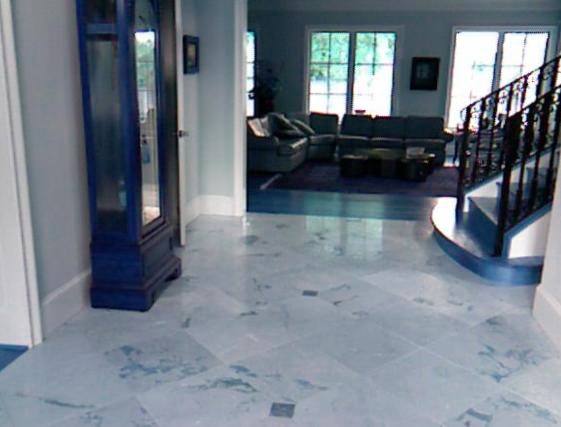

In [666]:
Image.fromarray(frameData.imgRGB)

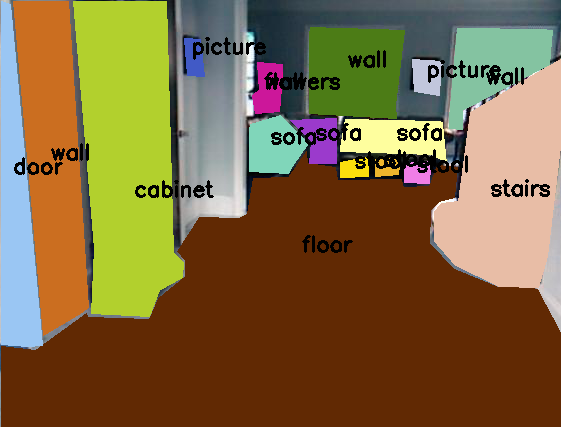

In [667]:
Image.fromarray(imgRGBWithAnnotations)

# Object counts

In [668]:
sun_annos_2d = {img: anno['2D3D'] for img, anno in sun_rgb_anno.items()}

In [669]:
img_objects= {}
for image_anno in sun_annos_2d.values():
    if image_anno:
        objects = [obj['name'] for obj in image_anno['objects'] if obj]
        img_objects[image_anno['name']] = len(objects)

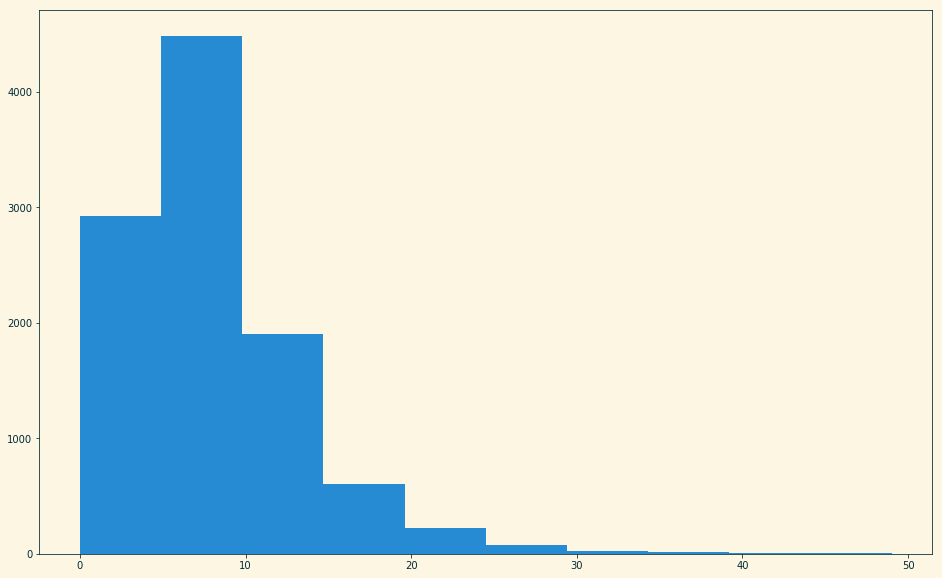

In [670]:
obj_freq_series = pd.Series(list(img_objects.values()))
_ = obj_freq_series[obj_freq_series < 80].hist()

In [618]:
object_counts = Counter()
for image_anno in sun_annos_2d.values():
    if image_anno:
        objects = [obj['name'].lower() for obj in image_anno['objects'] if obj]
        object_counts.update(objects)

In [619]:
freq_series = pd.Series(list(object_counts.values()))

In [671]:
len(freq_series[freq_series > 5])

391

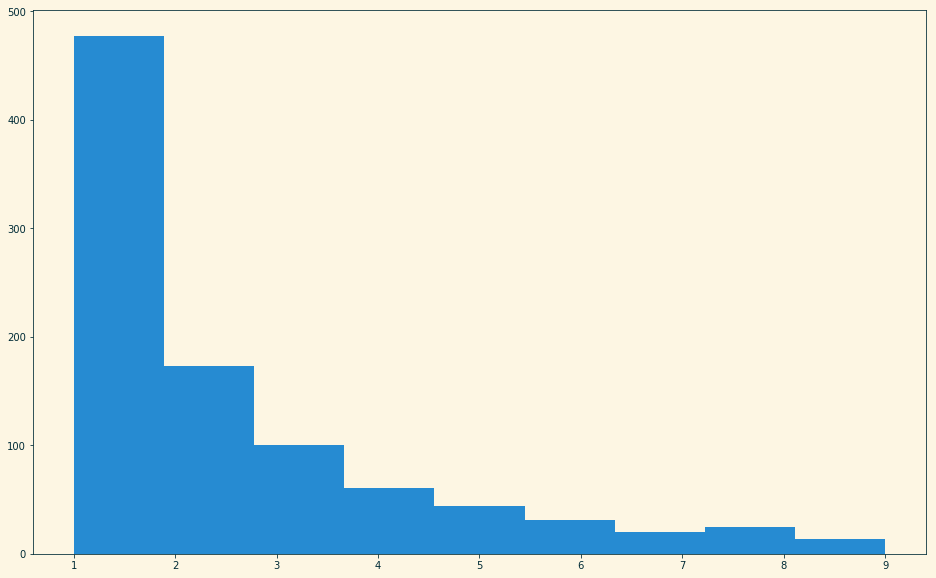

In [621]:
_ = freq_series[freq_series < 10].hist(bins=9)

In [622]:
sum(freq_series)

79569

In [623]:
object_freqs = object_counts.most_common()

In [604]:
len(object_freqs)

11287

In [631]:
object_counts['window']

44

In [172]:
filtered_objs = [ob for ob in object_freqs if ob[1] > 5]
class_freq_series = pd.Series([ob[1] for ob in  filtered_objs])

In [173]:
total_obj_instanc_count = sum(class_freq_series)

In [174]:
total_obj_instanc_count

162636

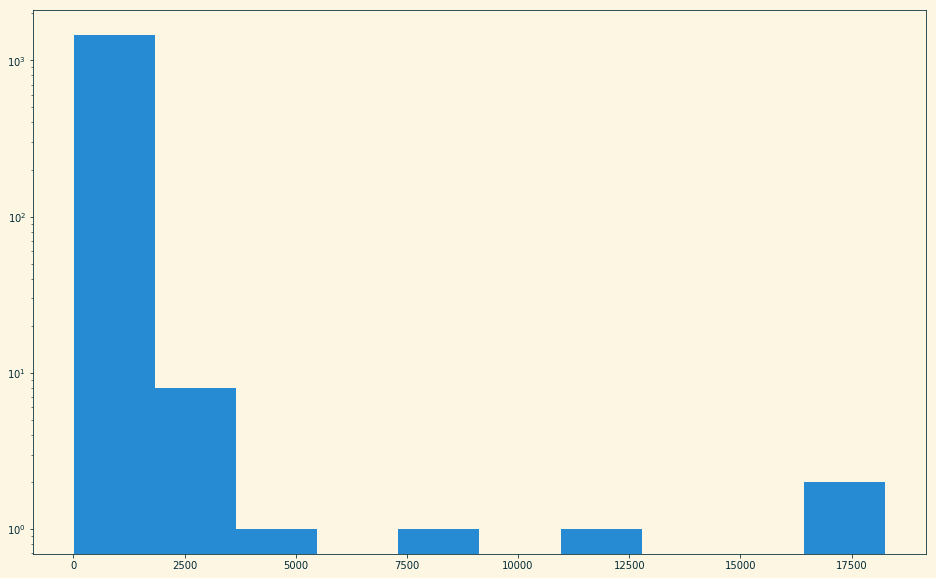

In [168]:
_ = class_freq_series.hist(log=True)

In [672]:
len(filtered_objs)

1467

In [176]:
sum([ob[1] for ob in filtered_objs[100:]])

35916

In [112]:
[ob for ob in object_freqs if 'garbage' in ob[0].lower()]

[('garbage_bin', 233),
 ('garbagecan', 68),
 ('GarbageCan', 35),
 ('garbage', 16),
 ('garbagebin', 9),
 ('garbagebag', 8),
 ('GARBAGECAN', 6),
 ('Garbage', 5),
 ('Garbagecan', 3),
 ('GarbageBin', 3),
 ('PlasticGarbage', 1),
 ('garbagecanlid', 1),
 ('GARBAGEDISPOSAL', 1),
 ('Garbagebag', 1),
 ('garbageplasticbag', 1),
 ('REFLECTIONGARBAGECAN', 1),
 ('Garbagecan2', 1),
 ('Garbagepicker', 1),
 ('GarbageandRecyclingBin', 1),
 ('GarbageBean', 1),
 ('GARBAGEBAGS?', 1),
 ('GarbageBag', 1),
 ('garbagebagsroll', 1),
 ('garbagedumpster', 1),
 ('garbagedisposalswitch', 1)]

# Image brightness

In [676]:
def mean_pixel_level(img_file):
    img = Image.open(img_file).convert('L')
    img_stats = ImageStat.Stat(img)
    return img_stats.mean[0]

def compute_img_brightnesses(image_files):
    img_brightnesses = {}
    for img in image_files:
#         img_brightnesses[img.split('/')[-1]] = mean_pixel_level(img)
        img_brightnesses[img] = mean_pixel_level(img)
    return img_brightnesses

In [677]:
%%time
n_processes = 8
pool = Pool(processes=n_processes)

img_split = np.array_split(image_names, n_processes)
pool_results = pool.map(compute_img_brightnesses, img_split)
img_brightnesses = {}
for res in pool_results:
    img_brightnesses.update(res)

CPU times: user 97 ms, sys: 110 ms, total: 208 ms
Wall time: 31.9 s


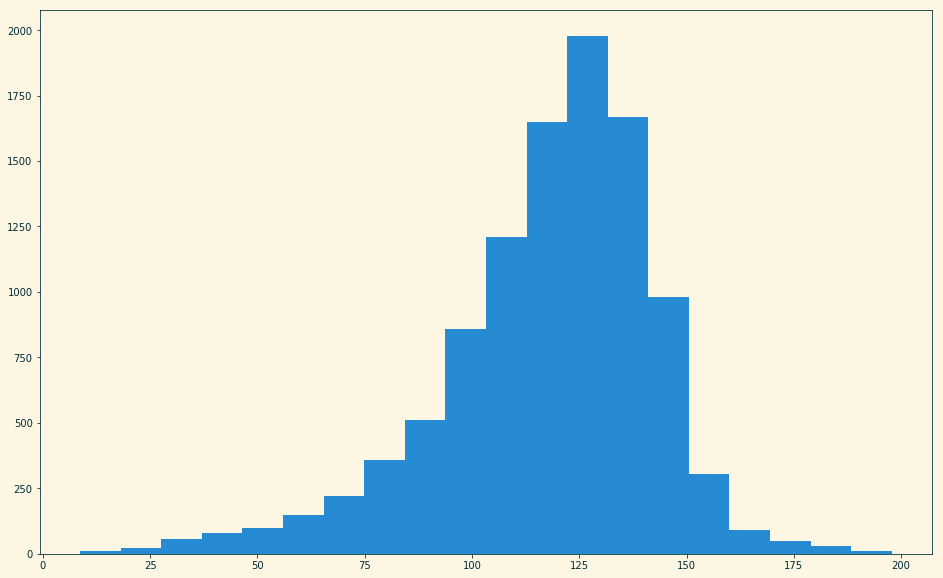

In [678]:
_ = pd.Series(list(img_brightnesses.values())).hist(bins=20)

In [680]:
dim_images = {k: v for k, v in img_brightnesses.items() if v > 50}

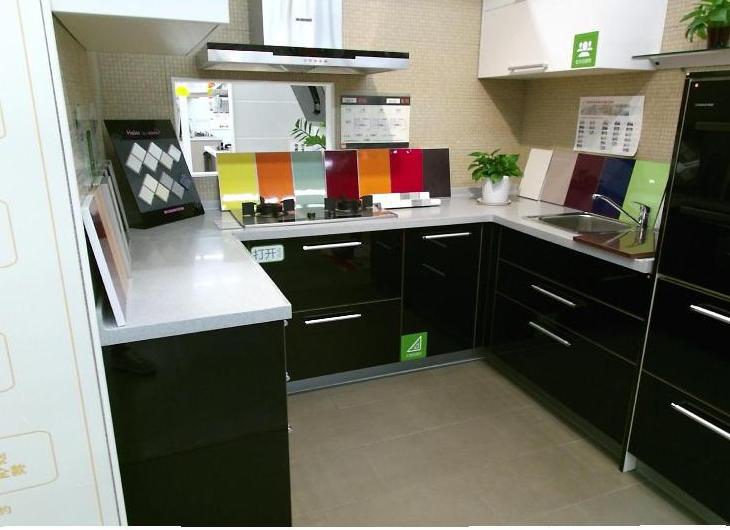

In [681]:
random_img = np.random.choice(list(dim_images.keys()), 1).item()
Image.open(random_img)

In [682]:
rare_objects = [ob[0] for ob in object_freqs if ob[1] < 5]
common_objects = [ob[0] for ob in object_freqs if ob[1] > 5]

In [683]:
object_list = [ob[0] for ob in object_freqs if ob[1] > 5]

In [684]:
len(object_list)

391

In [685]:
object_list

['chair',
 'table',
 'pillow',
 'desk',
 'sofa_chair',
 'lamp',
 'sofa',
 'door',
 'bed',
 'box',
 'shelf',
 'monitor',
 'garbage_bin',
 'cabinet',
 'computer',
 'endtable',
 'sink',
 'bookshelf',
 'night_stand',
 'drawer',
 'kitchen_counter',
 'dresser',
 'painting',
 'kitchen_cabinet',
 'coffee_table',
 'keyboard',
 'cpu',
 'ottoman',
 'tv',
 'picture',
 'stool',
 'recycle_bin',
 'file_cabinet',
 'whiteboard',
 'paper',
 'bench',
 'counter',
 'mirror',
 'toilet',
 'chair:occluded',
 'fridge',
 'printer',
 'curtain',
 'laptop',
 'bottle',
 'towel',
 'plant',
 'books',
 'book',
 'clothes',
 'microwave',
 'bag',
 'dresser_mirror',
 'papers',
 'cup',
 'stove',
 'bathroom_vanity',
 'back_pack',
 'bowl',
 'mouse',
 'chair:truncated',
 'cart',
 'tray',
 'person',
 'pillow:occluded',
 'bathtub',
 'bed:truncated',
 'telephone',
 'mug',
 'poster',
 'podium',
 'rack',
 'blinds',
 'speaker',
 'cubby',
 'tv_stand',
 'scanner',
 'bulletin_board',
 'plate',
 'suits_case',
 'projector',
 'blackboard

In [686]:
deduped_objs = set([ob.lower().split(':')[0] for ob in object_list])
len(deduped_objs)

363

# Look at v2 matlab files

In [687]:
from scipy.io.matlab import loadmat

In [688]:
updated_2d_bbs = loadmat('./SUNRGBDMeta2DBB_v2.mat')

In [689]:
updated_2d_bbs.keys()

dict_keys(['__header__', '__version__', '__globals__', 'SUNRGBDMeta2DBB'])

In [690]:
new_image_anno = updated_2d_bbs['SUNRGBDMeta2DBB'].T[2000]

In [691]:
field_names = new_image_anno.dtype.names

In [692]:
new_image_anno

array([ (array(['SUNRGBD/kv1/NYUdata/NYU0352'], 
      dtype='<U27'), array([[ (array([[0]], dtype=uint8), array([[  74.        ,    1.        ,  107.63075196,  310.02469136]]), array(['grandfatherclock'], 
      dtype='<U16'), array([[1]], dtype=uint8)),
        (array([[1]], dtype=uint8), array([[ 249.68237935,  113.09988777,   57.98765432,   57.50841751]]), array(['sofa'], 
      dtype='<U4'), array([[0]], dtype=uint8)),
        (array([[2]], dtype=uint8), array([[ 307.19079686,  112.14141414,   33.06734007,   49.84062851]]), array(['sofa'], 
      dtype='<U4'), array([[0]], dtype=uint8)),
        (array([[3]], dtype=uint8), array([[ 340.73737374,  114.5375982 ,   33.54657688,   35.94276094]]), array(['sofa'], 
      dtype='<U4'), array([[0]], dtype=uint8)),
        (array([[4]], dtype=uint8), array([[ 375.72166105,  116.45454545,   29.71268238,   31.62962963]]), array(['sofa'], 
      dtype='<U4'), array([[0]], dtype=uint8)),
        (array([[5]], dtype=uint8), array([[ 407.8305275

In [693]:
new_image_anno['groundtruth2DBB']

array([ array([[ (array([[0]], dtype=uint8), array([[  74.        ,    1.        ,  107.63075196,  310.02469136]]), array(['grandfatherclock'], 
      dtype='<U16'), array([[1]], dtype=uint8)),
        (array([[1]], dtype=uint8), array([[ 249.68237935,  113.09988777,   57.98765432,   57.50841751]]), array(['sofa'], 
      dtype='<U4'), array([[0]], dtype=uint8)),
        (array([[2]], dtype=uint8), array([[ 307.19079686,  112.14141414,   33.06734007,   49.84062851]]), array(['sofa'], 
      dtype='<U4'), array([[0]], dtype=uint8)),
        (array([[3]], dtype=uint8), array([[ 340.73737374,  114.5375982 ,   33.54657688,   35.94276094]]), array(['sofa'], 
      dtype='<U4'), array([[0]], dtype=uint8)),
        (array([[4]], dtype=uint8), array([[ 375.72166105,  116.45454545,   29.71268238,   31.62962963]]), array(['sofa'], 
      dtype='<U4'), array([[0]], dtype=uint8)),
        (array([[5]], dtype=uint8), array([[ 407.8305275 ,  115.97530864,   48.40291807,   51.75757576]]), array(['sof

In [195]:
new_image_anno['groundtruth2DBB'][0].dtype.names

('objid', 'gtBb2D', 'classname', 'has3dbox')

In [694]:
comp_k = [k for k in sun_rgb_anno.keys() if 'NYU0352' in k][0]

In [695]:
len(sun_rgb_anno[comp_k]['2D']['frames'][0]['polygon'])

17

In [696]:
sun_rgb_anno[comp_k]['2D']['objects']

[{'name': 'cabinet'},
 {'name': 'floor'},
 {'name': 'wall'},
 {'name': 'wall'},
 {'name': 'wall'},
 {'name': 'wall'},
 {'name': 'door'},
 {'name': 'picture'},
 {'name': 'picture'},
 {'name': 'flowers'},
 {'name': 'sofa'},
 {'name': 'sofa'},
 {'name': 'sofa'},
 {'name': 'stool'},
 {'name': 'stool'},
 {'name': 'stool'},
 {'name': 'stairs'}]

# Build dataset scaffolding

## explore

In [697]:
import PIL.Image as Image

import cv2
from SUNRGBDtoolbox_python.SUNRGBD import readFrame
import random as rand

In [698]:
rand_img_dir

'./SUNRGBD/xtion/sun3ddata/home_puigpunyen/home_puigpunyent_scan1_2012_aug_22/0005911-000446713989/'

In [699]:
random_img = np.random.choice(list(dim_images.keys()), 1).item()

rand_img_dir = random_img.split('image/')[0]
print(rand_img_dir)
frameData = readFrame(rand_img_dir, True )

imgRGBWithAnnotations = np.array(frameData.imgRGB, copy=True);

for i in range(0, len(frameData.annotation2D)):

    color = [rand.randint(0,255), rand.randint(0,255), rand.randint(0,255)]
        
    cv2.fillPoly(imgRGBWithAnnotations, [frameData.annotation2D[i]], color)

for i in range(0, len(frameData.annotation2D)):	
    data = frameData.annotation2D[i];
    centroid = np.mean(data,axis=0)
    cv2.putText(imgRGBWithAnnotations, frameData.labels2D[i], (int(centroid[0]), int(centroid[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.7, [0,0,0],2)

./SUNRGBD/kv2/kinect2data/002420_2014-06-28_20-26-12_260595134347_rgbf000030-resize/


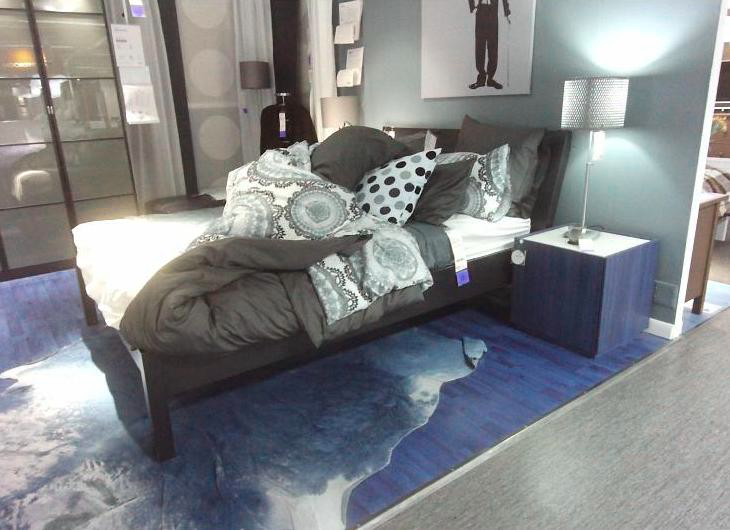

In [700]:
Image.fromarray(frameData.imgRGB)

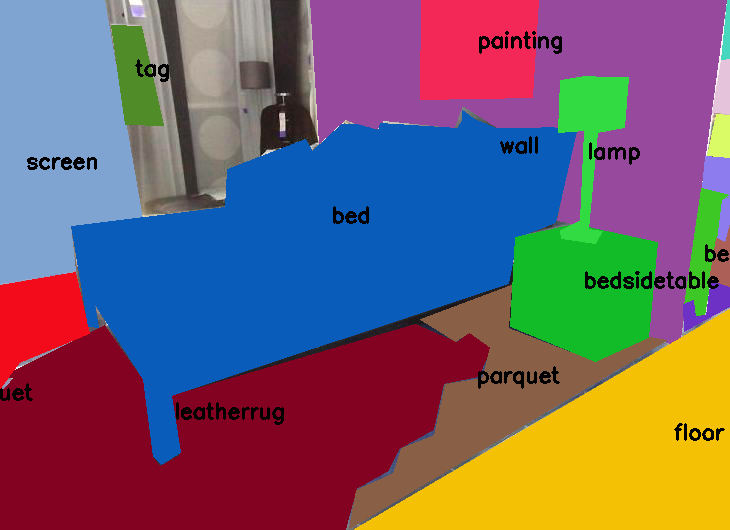

In [701]:
Image.fromarray(imgRGBWithAnnotations)

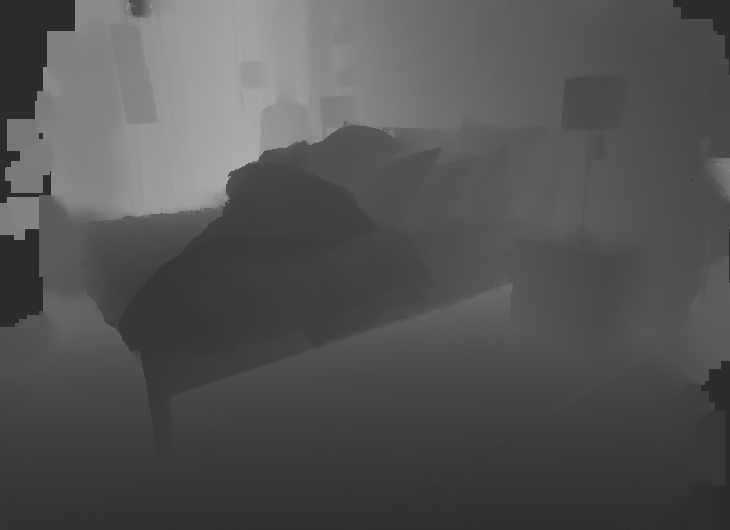

In [702]:
Image.fromarray(frameData.imgD)

plan for assembling this:

Could be a dict of image: to properties, including objects

or just objectIDs to objects, with image as property

each object needs:

id

2D poly, bbox

3D poly, depth, bounding cube

properties



In [327]:
print(sorted([ob2.item() for ob2 in [ob['classname'][0] for ob in  updated_2d_bbs['SUNRGBDMeta2DBB'].T[updated_2d_bbs['SUNRGBDMeta2DBB'].T['sequenceName'] == rand_img_dir[2:-1]]['groundtruth2DBB']][0].tolist()]))

['counter', 'island', 'shelf', 'shelf', 'stool', 'stool']


In [329]:
print(sorted([ob2.item() for ob2 in [ob['objid'][0] for ob in  updated_2d_bbs['SUNRGBDMeta2DBB'].T[updated_2d_bbs['SUNRGBDMeta2DBB'].T['sequenceName'] == rand_img_dir[2:-1]]['groundtruth2DBB']][0].tolist()]))

[0, 1, 2, 3, 4, 5]


In [333]:
rand_img_dir

'./SUNRGBD/xtion/sun3ddata/home_puigpunyen/home_puigpunyent_scan1_2012_aug_22/0005911-000446713989/'

In [335]:
print(sorted(frameData.labels2D))

['BACKSPLASH', 'BASKET', 'BOWL', 'CABINETS', 'CEILING', 'COUNTER', 'CUP', 'CUPBOARD', 'CUTTINGBOARD', 'FLOOR', 'FLOOR', 'GLASSJAR', 'GLASSJAR', 'GRINDER', 'ISLANDCABINETS', 'ISLANDCOUNTERTOP', 'JAR', 'JAR', 'JAR', 'KNIFEBLOCK', 'OVENMITT', 'OVENMITT', 'PAPERTOWELDISPENSER', 'RADIO', 'RANGEHOOD', 'SHELF', 'SHELF', 'SPICERACK', 'STOVE', 'TOWEL', 'UNIDENTIFIABLE', 'UNIDENTIFIABLE', 'UNIDENTIFIABLE', 'UNIDENTIFIEABLE', 'WALL', 'WOODENSPOONRACK', 'WOODENSPOONS']


In [345]:
_ = [print(an.shape) for an in frameData.annotation2D]

(6, 2)
(9, 2)
(3, 2)
(4, 2)
(5, 2)
(21, 2)
(4, 2)
(5, 2)
(10, 2)
(6, 2)
(10, 2)
(15, 2)
(4, 2)
(6, 2)
(4, 2)
(9, 2)
(6, 2)
(39, 2)
(5, 2)
(7, 2)
(8, 2)
(9, 2)
(4, 2)
(12, 2)
(10, 2)
(4, 2)
(3, 2)
(7, 2)
(5, 2)
(4, 2)
(5, 2)
(5, 2)
(4, 2)
(14, 2)
(3, 2)
(3, 2)
(4, 2)


## code

In [703]:
tp = frameData.annotation2D[0]

In [705]:
tp

array([[726,  -1],
       [679, 346],
       [649, 336],
       [657, 241],
       [557, 220],
       [577, 127],
       [498, 128],
       [462, 105],
       [454, 127],
       [383, 120],
       [375, 131],
       [345, 119],
       [319, 143],
       [310,  -1]], dtype=int32)

In [706]:
tp[:,:1]

array([[726],
       [679],
       [649],
       [657],
       [557],
       [577],
       [498],
       [462],
       [454],
       [383],
       [375],
       [345],
       [319],
       [310]], dtype=int32)

In [709]:
# def bbox_from_poly(polygon):
#     bbox = 
#     return bbox

# hide 

In [ ]:
# sum(obj_freq_series.apply(lambda x: x * (x-1)/2)) / 10**6

In [332]:
# updated_2d_bbs['SUNRGBDMeta2DBB'].T[updated_2d_bbs['SUNRGBDMeta2DBB'].T['sequenceName'] == rand_img_dir[2:-1]]

In [ ]:
test_anno = list(sun_rgb_anno.values())[50]